# Surface Data for 2012-2013 
#### includes data from upriver, downriver, and midestuary

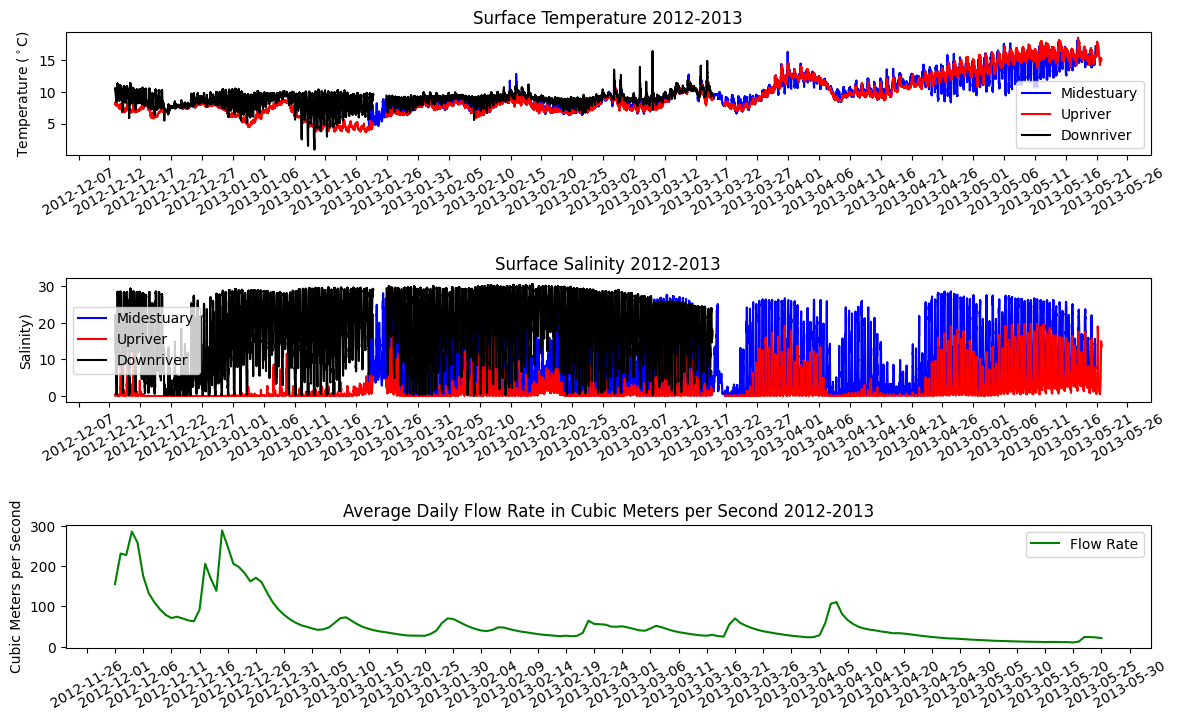

In [6]:
import pandas as pd
import scipy.io as sio
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

def Array_To_DataFrame(matDF, varName) :
    npArray = np.array([])
    for i in range (matDF[varName].shape[0]) :
        npArray = np.concatenate((npArray, matDF[varName][i].flatten()))
    return npArray

# import files for 2012-2013 and extract surface data
#import upriver surface data
matDataSU1 = sio.loadmat('2012-13\\hobo_upriver_3827_Dep1.mat')
matDataSU2 = sio.loadmat('2012-13\\hobo_upriver_3827_Dep2.mat')
matDataSU3 = sio.loadmat('2012-13\\hobo_upriver_3827_Dep3.mat')

#import downriver surface data
matDataS1 = sio.loadmat('2012-13\\hobo_dnriver_3829_Dep1.mat')
matDataS2 = sio.loadmat('2012-13\\hobo_dnriver_3829_Dep2.mat')

#import midestuary surface data
matDataMid = sio.loadmat('2012-13\\hobo_PrivateDock_01.mat')

#mat lab date origin
origin = np.datetime64('0000-01-01', 'D') - np.timedelta64(1, 'D')

#upriver surface data
matDataSU1Filtered = {dictKey:dictValue for dictKey, dictValue in matDataSU1.items() if dictKey[0] != '_'}
matS1DF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataSU1Filtered.items()})
matDataSU2Filtered = {dictKey:dictValue for dictKey, dictValue in matDataSU2.items() if dictKey[0] != '_'}
matS2DF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataSU2Filtered.items()})
matDataSU3Filtered = {dictKey:dictValue for dictKey, dictValue in matDataSU3.items() if dictKey[0] != '_'}
matS3DF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataSU3Filtered.items()})

matUDSF = pd.concat([matS1DF, matS2DF, matS3DF])
tmsUSurfaceriver = matUDSF['DN'] * np.timedelta64(1, 'D') + origin


#downriver surface data
matDataS1Filtered = {dictKey:dictValue for dictKey, dictValue in matDataS1.items() if dictKey[0] != '_'}
matD1SF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataS1Filtered.items()})
matDataS2Filtered = {dictKey:dictValue for dictKey, dictValue in matDataS2.items() if dictKey[0] != '_'}
matD2SF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataS2Filtered.items()})

matDDSF = pd.concat([matD1SF, matD2SF])
tmsDSurfaceriver = matDDSF['DN'] * np.timedelta64(1, 'D') + origin

#mid estuary data
matDataMidFiltered = {dictKey:dictValue for dictKey, dictValue in matDataMid.items() if dictKey[0] != '_'}
matMidDF = pd.DataFrame({dictKey: np.array(dictValue).flatten() for dictKey, dictValue in matDataMidFiltered.items()})

# create numpy array that contains time and other variables
matMidTimeArray = Array_To_DataFrame(matMidDF, 'DN')
matMidSurfaceSalinityArray = Array_To_DataFrame(matMidDF, 'SS')
matMidBottomSalinityArray = Array_To_DataFrame(matMidDF, 'SB')
matMidBottomPressureArray = Array_To_DataFrame(matMidDF, 'BP')
matMidBottomTemperatureArray = Array_To_DataFrame(matMidDF, 'TB')
matMidSurfaceTemperatureArray = Array_To_DataFrame(matMidDF, 'TS')

matMidFlatDF = pd.DataFrame({'DN' : matMidTimeArray.flatten(), 'SS' : matMidSurfaceSalinityArray.flatten(), 'SB' : matMidBottomSalinityArray.flatten(), 'BP' : matMidBottomPressureArray.flatten(), 'TB' : matMidBottomTemperatureArray.flatten(), 'TS' : matMidSurfaceTemperatureArray.flatten()})

#interpolate the data
matMidFlatDF.interpolate(method = 'linear', inplace = True)

#set new time style
tmsMidriver = matMidFlatDF['DN'] * np.timedelta64(1, 'D') + origin

#reading in flow data
flowDF = pd.read_csv('2012_2013alsea.csv')
flowDF['fRate'] = flowDF['max_va'] * 0.0283168
#create a new column for flow dates
for index, row in flowDF.iterrows():
    calcDate = pd.Timestamp(year=int(row['begin_yr']), month=int(row['month_nu']), day=int(row['day_nu']))
    flowDF.loc[index, 'DN'] = calcDate

tmsFlow = flowDF['DN']

#create the subplots
fig, (axtemp, axsal, axflow) = plt.subplots(3,figsize=(14, 8))

#set the titles for the plots
axtemp.set_title("Surface Temperature 2012-2013")
axsal.set_title("Surface Salinity 2012-2013")
axflow.set_title("Average Daily Flow Rate in Cubic Meters per Second 2012-2013")

#set up the y axis for each plot
plt.setp(axtemp, ylabel = "Temperature ($^\circ$C)")
plt.setp(axsal, ylabel = "Salinity)")
plt.setp(axflow, ylabel = "Cubic Meters per Second")

#plot the data on the proper plot
axtemp.plot(tmsMidriver, matMidFlatDF['TS'], color = 'blue', label='Midestuary')
axtemp.plot(tmsUSurfaceriver, matUDSF['T'], color = 'red', label = 'Upriver')
axtemp.plot(tmsDSurfaceriver, matDDSF['T'], color = 'black', label = 'Downriver')

axsal.plot(tmsMidriver,matMidFlatDF['SS'],color = 'blue', label = "Midestuary")
axsal.plot(tmsUSurfaceriver, matUDSF['S'],color = 'red', label = "Upriver")
axsal.plot(tmsDSurfaceriver, matDDSF['S'],color = 'black', label = "Downriver")

axflow.plot(tmsFlow,flowDF['fRate'], color = 'green', label = 'Flow Rate')


# Change the tick interval
axtemp.xaxis.set_major_locator(mdates.DayLocator(interval=5)) 
axsal.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axflow.xaxis.set_major_locator(mdates.DayLocator(interval=5))

# Puts x-axis labels on an angle
axtemp.xaxis.set_tick_params(rotation = 30)  
axsal.xaxis.set_tick_params(rotation = 30)
axflow.xaxis.set_tick_params(rotation = 30)

#adjust space between the plots
plt.subplots_adjust(hspace=1)

axtemp.legend() 
axsal.legend()
axflow.legend()
plt.show()